In [1]:
import pandas
import numpy
import datetime
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter, MinuteLocator
from matplotlib.ticker import FuncFormatter, MaxNLocator
%pylab inline

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/scipy/cluster/vq.py:88: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _vq
/usr/local/lib/python2.7/dist-packages/scipy/cluster/hierarchy.py:178: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _hierarchy


In [2]:
# Read SD data from the csv file
sdDF1 = pandas.read_csv("../data/sd-params-20110412.csv",\
                        parse_dates=['date'])
sdDF1.head()

,beam,date,gate,gazm,glat,glon,gsct,mazm,mlat,mlon,vel
0,23,2011-04-12 00:02:00,38,21.15,58.41,-112.19,0,12.82,65.98,-51.75,-36.4
1,23,2011-04-12 00:02:00,39,21.49,58.79,-111.91,1,13.16,66.39,-51.52,-4.4
2,23,2011-04-12 00:02:00,40,21.84,59.16,-111.62,1,13.51,66.79,-51.29,5.2
3,23,2011-04-12 00:02:00,41,22.20,59.54,-111.33,1,13.86,67.19,-51.04,-0.9
4,23,2011-04-12 00:02:00,42,22.56,59.91,-111.02,1,14.22,67.59,-50.78,-2.5


In [3]:
# Read OMN data
omnDF1 = pandas.read_csv("../data/omn-20110412.csv",\
                        parse_dates=['date'])
omnDF1.head()

,date,Bz,By,ief
0,2011-04-12 00:00:00,5.46,5.46,-2.53
1,2011-04-12 00:01:00,7.73,7.73,-3.60
2,2011-04-12 00:02:00,7.24,7.24,-3.44
3,2011-04-12 00:03:00,6.47,6.47,-3.07
4,2011-04-12 00:04:00,5.98,5.98,-2.83


In [55]:
# re-organize SD data for RTIish plotting
selBeam = 7
rtiStDate = datetime.datetime(2011,4,12,9)
rtiEndDate = datetime.datetime(2011,4,12,12,30)
velScale = [ -500, 500 ]
vLineDates = [ datetime.datetime(2011,4,12,10, 12) ]
seaMap = ListedColormap(sns.color_palette("coolwarm_r"))

rtiDF = sdDF1[ (sdDF1["date"] >= rtiStDate) & (sdDF1["date"] <= rtiEndDate) &\
              (sdDF1["beam"] == selBeam) ].reset_index().dropna()
rtiDF["dtNum"] = [ date2num(x) for x in rtiDF["date"] ]
plotDF = rtiDF[ ["mlat", "dtNum",\
                        "vel"] ].drop_duplicates(\
            subset=["mlat", "dtNum"]).pivot( "mlat", "dtNum" )
# 
mlatVals = plotDF.index.values
timeVals = plotDF.columns.levels[1].values
timeCntr, mlatCntr  = numpy.meshgrid( timeVals, mlatVals )
# Mask the nan values! pcolormesh can't handle them well!
# vLosVals = numpy.ma.masked_where(numpy.isnan(plotDF["v"].values),plotDF["v"].values)
# rtiPlot = ax.pcolormesh(timeCntr, mlatCntr, vLosVals, cmap=seaMap, vmin=velScale[0],vmax=velScale[1])
# ax.set_xlim( [ rtiStDate, rtiEndDate ] )
# ax.set_xlabel("TIME (UT)")
# ax.set_ylabel("GATE")
# ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

# cbar = plt.colorbar(rtiPlot, orientation='vertical')
# cbar.set_label("L-o-S velocity [m/s]")

In [56]:
sns.set_style("whitegrid")
sns.set_context("poster")
plt.style.use("fivethirtyeight")

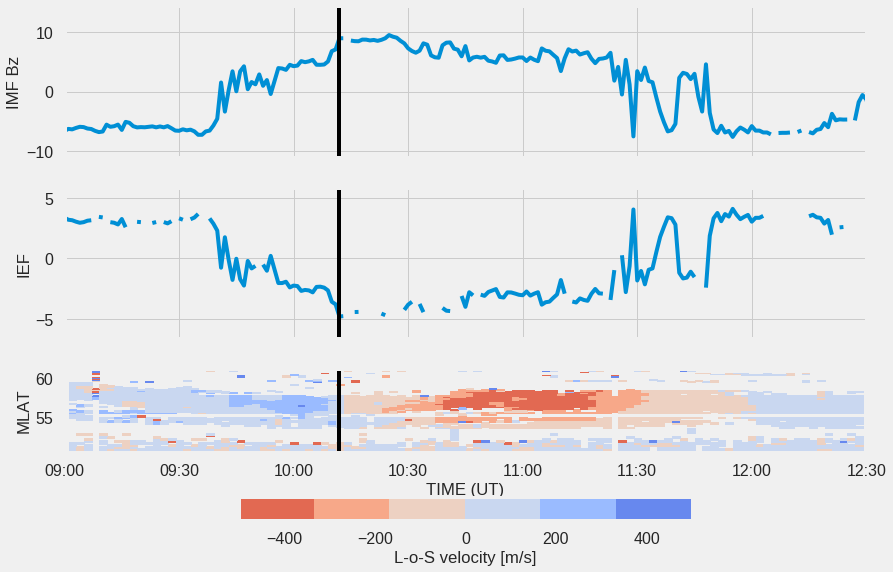

In [57]:
f, axArr = plt.subplots(3, sharex=True)
# Plot IMF
axArr[0].plot(omnDF1["date"].values, omnDF1["Bz"].values)
axArr[0].set_ylabel("IMF Bz")
axArr[1].plot(omnDF1["date"].values, omnDF1["ief"].values)
axArr[1].set_ylabel("IEF")
# Plot RTI
# Mask the nan values! pcolormesh can't handle them well!
vLosVals = numpy.ma.masked_where(numpy.isnan(plotDF["vel"].values),\
                                plotDF["vel"].values)
rtiPlot = axArr[2].pcolormesh(timeCntr, mlatCntr,\
                        vLosVals, cmap=seaMap, vmin=velScale[0],vmax=velScale[1])
axArr[2].set_ylabel("MLAT")
# ax.set_xlim( [ rtiStDate, rtiEndDate ] )
axArr[-1].set_xlabel("TIME (UT)")
axArr[-1].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

cbar = plt.colorbar(rtiPlot, orientation='horizontal', ax=axArr[2], shrink=0.8, pad=0.3)
cbar.set_label("L-o-S velocity [m/s]")
# setup xlim
for ax in axArr:
    ax.set_xlim( [ rtiStDate, rtiEndDate ] )
    for _vd in vLineDates:
        ax.axvline(x=_vd, c="k")